<div class="span5 alert alert-info" style="background-color:Gainsboro">  

<h1> 
  From Russia with love, or (being Bullish on a [Russian] Bear market) ... 
</h1>
<br/>


*"Housing costs demand a significant investment from both consumers and developers. And when it comes to planning a 
budget—whether personal or corporate—the last thing anyone needs is uncertainty about one of their biggets expenses. 
**Sberbank**, Russia’s oldest and largest bank, helps their customers by making predictions about realty prices so renters, developers, and lenders are more confident when they sign a lease or purchase a building.*

*Although the housing market is relatively stable in Russia, the country’s volatile economy makes forecasting prices 
as a function of apartment characteristics a unique challenge. Complex interactions between housing features such 
as number of bedrooms and location are enough to make pricing predictions complicated. Adding an unstable economy 
to the mix means Sberbank and their customers need more than simple regression models in their arsenal."*

Thus states the introduction to the Kaggle competition where Sberbank wants contestants to tame Russia's feral realty market through accurate housing price predictions. The data provided contains the usual information about the specifics of the housing units themselves, i.e. number of rooms, location, etc. However, in addition to the typical habitation fare macro economic data is also included. The number of features available in the raw data for prediction is well over 700. 
</div>

In [2]:
#!conda install matplotlib

In [3]:
import pandas as pd
import os 
import numpy as np
import seaborn as sns
import collections
import csv
import missingno as msno
# https://github.com/ResidentMario/missingno
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
import xgboost as xgb

import datetime as dt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['KMP_DUPLICATE_LIB_OK']='True'

%matplotlib inline

<div class="span5 alert alert-info" style="background-color:Gainsboro">  

<h1> 
Exploratory Data Analysis
</h1>
<br/>

Exploratory Data Analysis (EDA) is the process by which the data is scrupulously analyzed for irregularities that could harm or, potentially, help with the statistical modelling and machine learning that will follow. Below are some questions that were asked and answered during the EDA process:
1. What is the state of the raw data? Messy? Clean?
2. What was done to clean messy data?
3. Are there many missing values? 
4. How should the missing values be dealt with?
5. Are there many outliers in the data?
6. Do the outliers affect the model(s)?
7. Should oultiers be removed, replaced or ignored?
8. What hypotheses, if any, present themselves from the data?

</div>

In [4]:
# read in the data
print (dt.datetime.now())
skip = ['price_cat','id','timestamp','price_doc']
dir_path = os.getcwd() + '/../../../../data/all/'
df = pd.read_csv(dir_path + 'train.csv')
df_macro = pd.read_csv(dir_path + 'macro.csv')

# create a new target variable called 'price_cat' for price category.
df['price_length'] = [7.5 if cat > 6e6 and cat < 1e7 else len(str(cat)) for cat in df['price_doc'] ]    
df['price_length'] = [l if l < 8 else 8 for l in df['price_length']]    
df['price_cat'] = df['price_length'].astype('category').cat.codes    

# there is only one record in price_cat 4, so make it a price_cat 3.
df.loc[df.price_cat == 4, 'price_cat'] = 3
df.loc[df.price_cat == 0, 'price_cat'] = 1


# join the two dataframes together
df_eda = pd.merge(df, df_macro, how='inner', on='timestamp', left_on=None, right_on=None,
     left_index=False, right_index=False, sort=True,
     suffixes=('_x', '_y'), copy=True, indicator=False,
     validate=None)

null_yr = 9999.0
yr = dt.datetime.now().year
# take care of bad dates, dates too old, too far out into the future, or NaN. Set them all to 9999.0
for i in df_eda['build_year'].index:
    if df_eda.loc[i, 'build_year'] < 1700 or np.isnan(df_eda.loc[i, 'build_year']) \
            or df_eda.loc[i, 'build_year'] > yr:
        df_eda.loc[i, 'build_year'] = null_yr

df_eda.drop(['price_length','id', 'timestamp'], inplace=True, axis=1)
df_eda.loc[df_eda[df_eda['state'] == 33.0].index, 'state'] = 3.0
print (dt.datetime.now())    

2019-02-19 10:07:17.025139
2019-02-19 10:07:30.480523


In [5]:
d = 5.3e6
d2 = 7.4e6
print(d)
print(df_eda.shape)
i0 = df_eda.loc[df_eda.price_doc <= d,'full_sq'].index
v0 = df_eda.loc[i0,'full_sq'].count()
i1 = df_eda.loc[(df_eda.price_doc > d) & (df_eda.price_doc <= d2),'full_sq'].index
v1 = df_eda.loc[i1,'full_sq'].count()
i2 = df_eda.loc[(df_eda.price_doc > d2),'full_sq'].index
v2 = df_eda.loc[i2,'full_sq'].count()

print(v0)
print(v1)
print(v2)
df_eda.loc[i0,'price_category'] = 0
df_eda.loc[i1,'price_category'] = 1
df_eda.loc[i2,'price_category'] = 2


np.sum(df_eda.price_category == 2)
print(v0+v1+v2)
print(df_eda.price_category.head())

5300000.0
(30471, 390)
10164
10198
10109
30471
0    1.0
1    1.0
2    1.0
3    2.0
4    2.0
Name: price_category, dtype: float64


In [6]:
for i in range(1,4):    
    print('price_cat ',i, 'min: ', df_eda.loc[df_eda.price_cat == i, 'price_doc'].min())
    print('price_cat ',i, 'count: ', df_eda.loc[df_eda.price_cat == i, 'price_doc'].count())
    print('price_cat ',i, 'max: ', df_eda.loc[df_eda.price_cat == i, 'price_doc'].max())


price_cat  1 min:  100000
price_cat  1 count:  13983
price_cat  1 max:  6000000
price_cat  2 min:  6000401
price_cat  2 count:  11678
price_cat  2 max:  9991069
price_cat  3 min:  10000000
price_cat  3 count:  4810
price_cat  3 max:  111111112


In [7]:
df_eda.price_category.value_counts()

1.0    10198
0.0    10164
2.0    10109
Name: price_category, dtype: int64

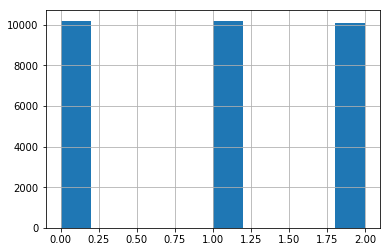

In [8]:
df_eda.price_category.hist()

In [9]:
# cols.csv has the columns listed as either categorical or not. 
# make a list for the categorical variables and one for the rest.
catlist = []
with open('cols.csv', 'r') as csvfile:
    file = csv.reader(csvfile, delimiter=' ')
    for row in file:
        cl = row[0].split(",")[1].replace('"','').replace("'",'').replace('(','')
        if cl not in skip:
            tp = row[0].split(",")[0]
            if tp == 'cat':
                catlist.append(cl)

rest = [col for col in df_eda.columns if col not in catlist]
print(len(catlist))
print(len(rest))

68
324


<div class="span5 alert alert-info" style="background-color:Gainsboro">  

<h2> 
Messy Data
</h2>
<br/>

The messiest parts of the data are the missing values. They will be dealt with next. For now, there are some issues with the values for some of the columns.


<h3> 
build_year
</h3>
<br/>

The field build_year has some invalid years (probably the result of typos) that need to be taken care of. There are also some years that are way out in the future and years from the distant past. The messy data for build_year was taken care of in the cell that starts with the comment '# read in the data'. All the values for build_year before 1700 and greater than 2018 (the current year) were set to 9999. All null values were set to 9999 as well. The bad years and nulls were set to 9999 so that all irregularities can be taken care of at once. 


<h3> 
Missing Data
</h3>
<br/>

Find out the extent of the problem by finding the columns with missing data and graphing them using the missingno library from python.

</div>

In [10]:
# Identify columns with missing data and columns that are complete
df_len = df_eda.shape[0]
misslist = []
complete_list = []
for col in rest:
    misscount = df_len - df_eda[col].describe()['count']
    if misscount != 0:
        misslist.append((misscount,col))
    else:
        complete_list.append(col)

print(len(misslist))
print(len(complete_list))
misslist = sorted(misslist,reverse=False)
#misslist
least_incomplete_fifty = [col[1] for col in misslist[:50]]


88
236


#### Bar Chart: Count of Values per Column that are NOT null (50 most numerous)
msno.bar is a simple visualization of nullity by column:

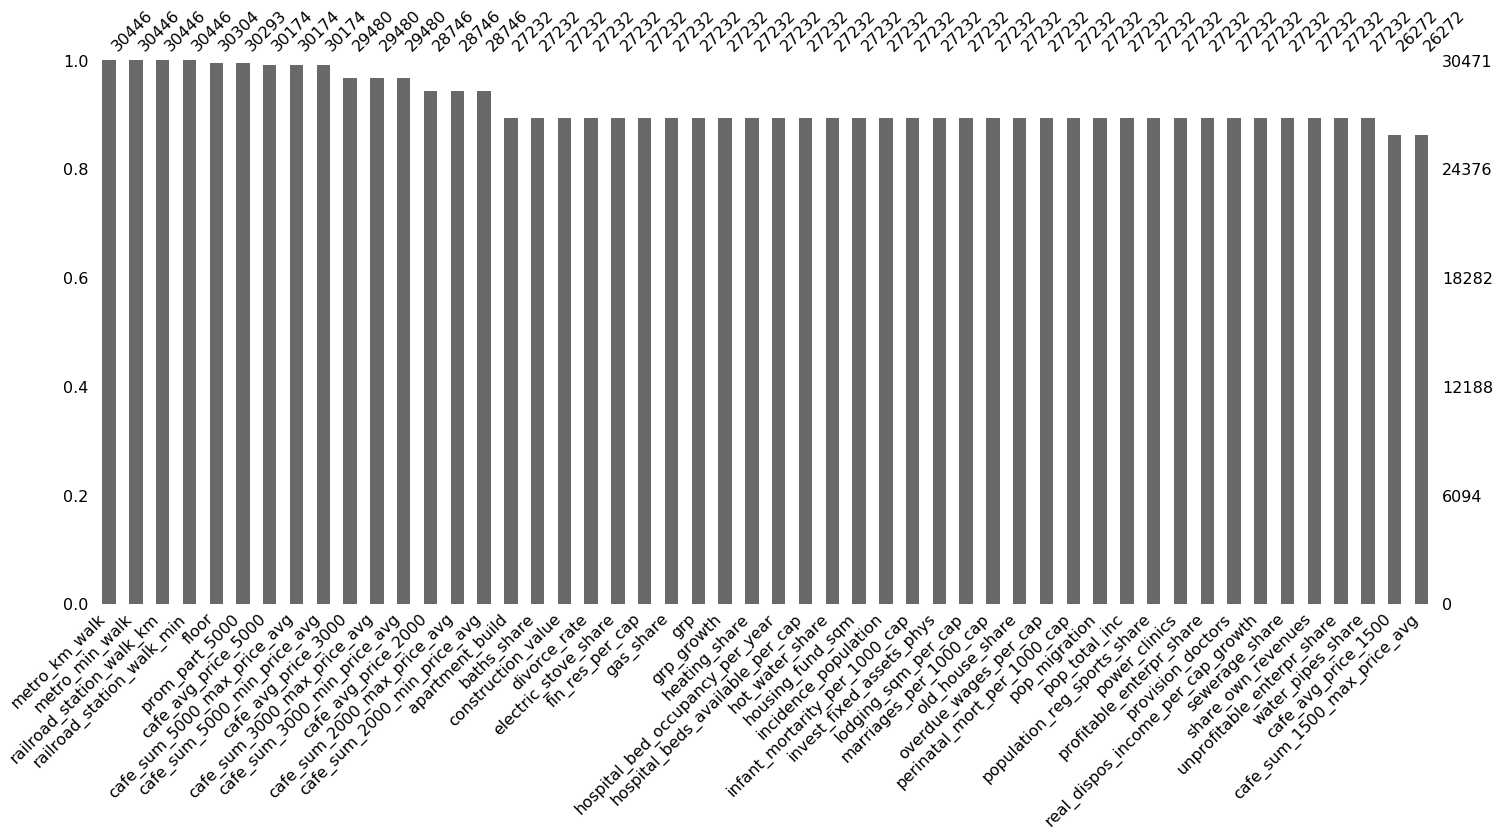

In [11]:
# chart shows the 50 columns from the list of columns with missing values that have the fewest nulls
msno.bar(df_eda[least_incomplete_fifty])

#### Bar Chart: Count of Values per Column that are NOT null (50 cols with most nulls)

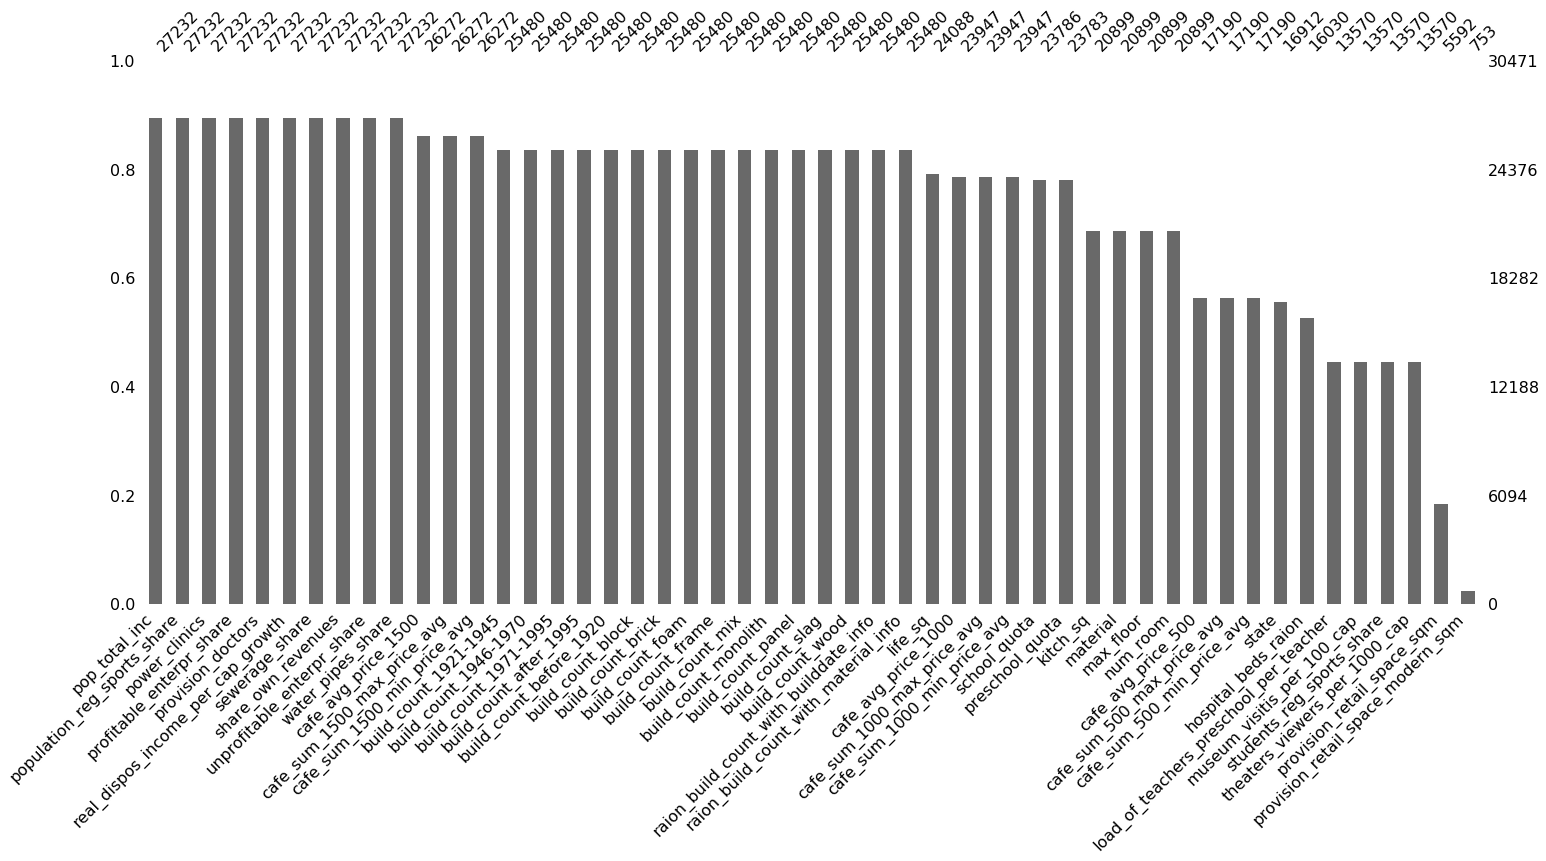

In [12]:
most_incomplete_fifty = [col[1] for col in misslist[-50:]]
most_incomplete_fifty[:5]
msno.bar(df_eda[most_incomplete_fifty])

#### Complete Data
Of the variables that end up as a part of the final model(s), most of the major contributors have all of their data. The two notable excpetions are 'life_sq' and 'floor'. The nulls for these features will be replaced by the median for their respective columns. This will have an effect on the 'diff_sq' feature that is created from the subtraction of 'life_sq' from 'full_sq'. But no other engineered fields are affected.

The graph below shows the fullness counts of the major contributors.

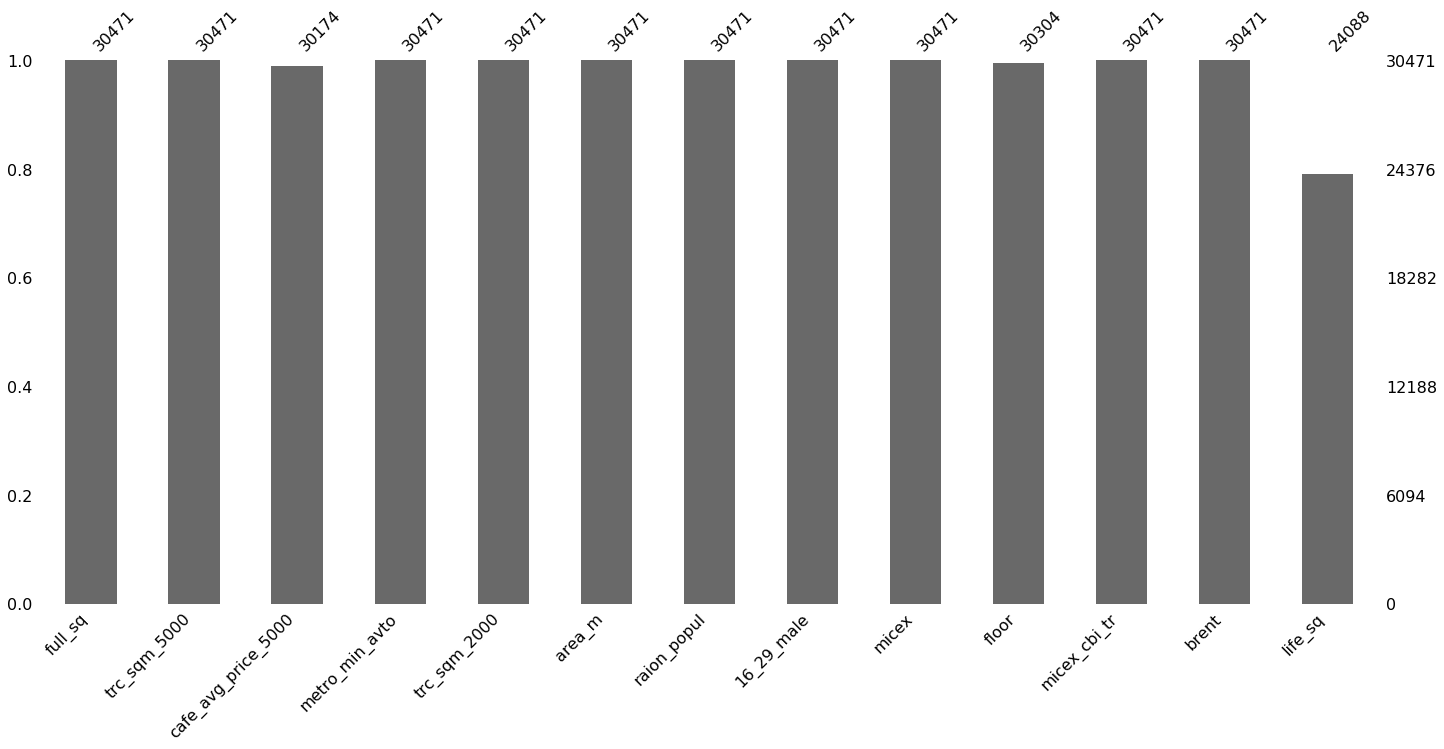

In [13]:
slist = ['full_sq','trc_sqm_5000',  'cafe_avg_price_5000', 'metro_min_avto', 'trc_sqm_2000'\
        , 'area_m','raion_popul','16_29_male', 'micex', 'floor', 'micex_cbi_tr','brent','life_sq']

msno.bar(df_eda[slist])

#### Heatmap: Correlation between columns regarding null or not null
The missingno correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another.

It appears from the heatmap below that many fields are null or not null together. It makes sense that some field pairs like 'grp' and 'grp_growth' would have a high nullity correlation.  


*add three or four main points*

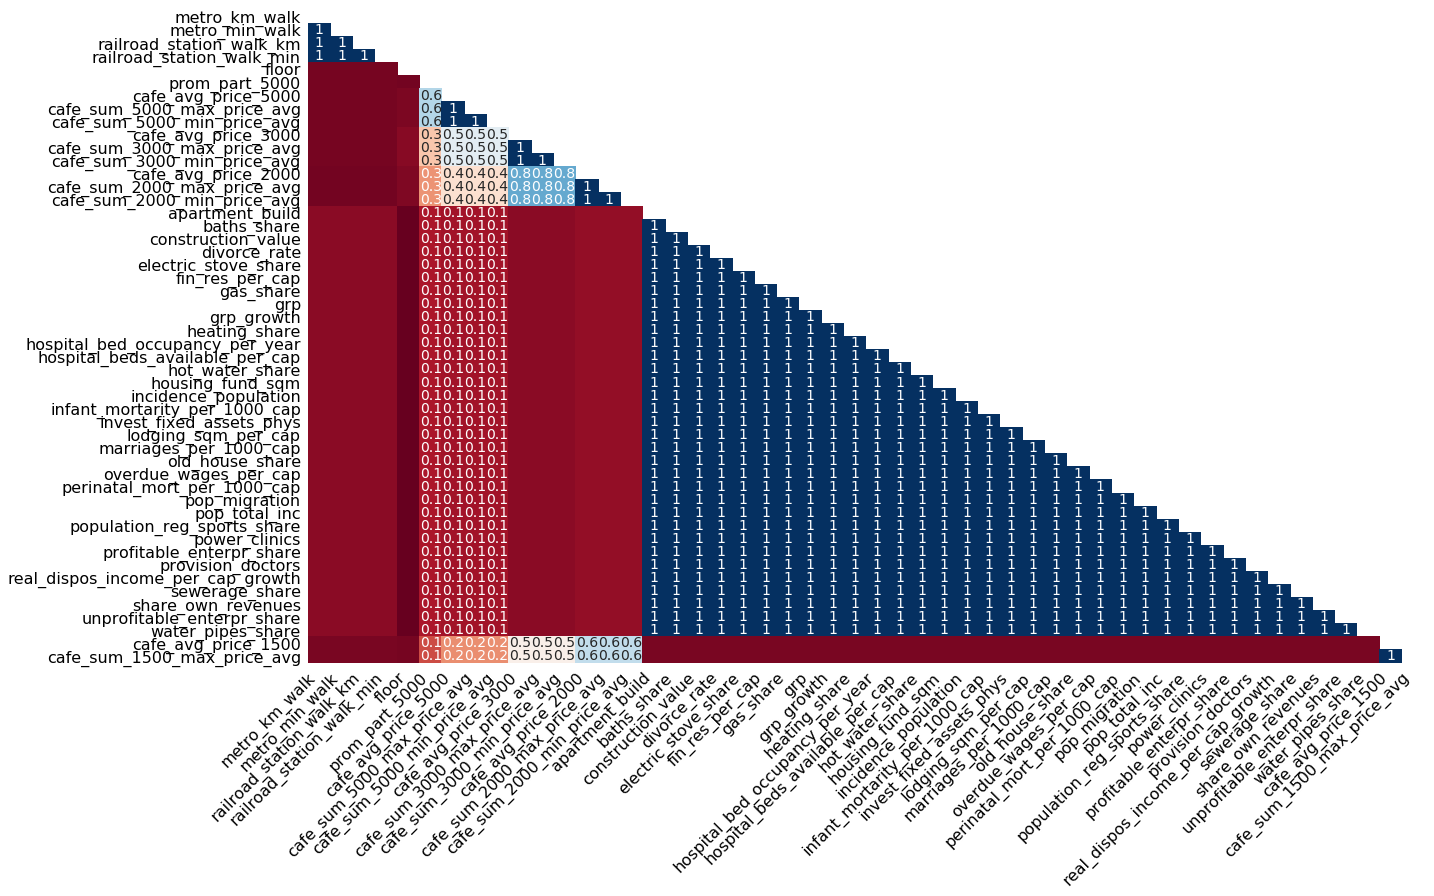

In [14]:
msno.heatmap(df_eda[least_incomplete_fifty])

#### Dendrogram: Also shows the correlations between columns regarding null and not null
The dendrogram allows you to more fully correlate variable completion, revealing trends deeper than the pairwise ones visible in the correlation heatmap.

The Dendrogram also shows the correlation between similar fields regarding when or whether they are null. This provides more evidence, if it was needed, that many features are null or not together. 

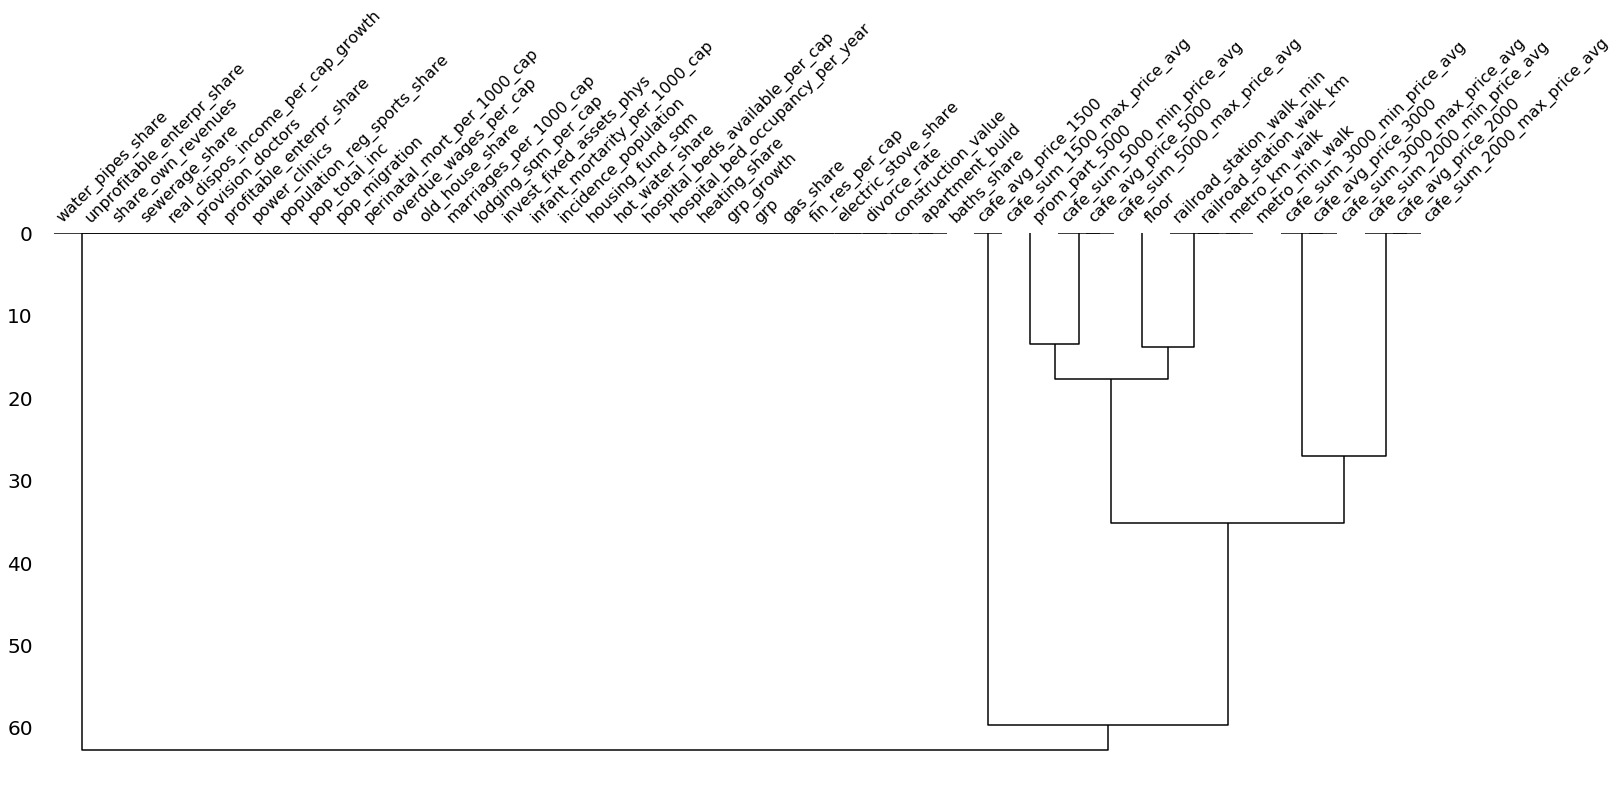

In [15]:
msno.dendrogram(df_eda[least_incomplete_fifty])

### Missing Data: Conclusion
Missing data does not seem to be a large factor according to the graphs. The fields that will end up being used by the models have most of their data. Where there are nulls they will be replaced by the median for that column. The median was chosen instead of the mean because of the next issue to be discussed--outliers. 

## Outliers:
Outliers can be a problem for statistical modelling if they distort the true relationship between the explanatory variables and the target. Next, we'll explore the extent of the outlier issue, if there is one, and come up with some solutions to this potential issue. 

In [16]:
km_list = ['additional_education_km', 'basketball_km', 'big_church_km', 'big_market_km', 'big_road1_km', \
           'big_road2_km', 'bulvar_ring_km', 'bus_terminal_avto_km', 'catering_km', 'cemetery_km', \
           'church_synagogue_km', 'detention_facility_km', 'exhibition_km', 'fitness_km', 'green_zone_km', \
           'hospice_morgue_km', 'ice_rink_km', 'incineration_km', 'industrial_km', 'kindergarten_km', 'kremlin_km', \
           'market_shop_km', 'metro_km_avto', 'metro_km_walk', 'mkad_km', 'mosque_km', 'museum_km',\
           'nuclear_reactor_km', 'office_km', 'oil_chemistry_km', 'park_km', 'power_transmission_line_km',\
           'preschool_km', 'public_healthcare_km', 'public_transport_station_km', 'radiation_km', 'railroad_km', \
           'railroad_station_avto_km', 'railroad_station_walk_km', 'sadovoe_km', 'school_km', 'shopping_centers_km', \
           'stadium_km', 'swim_pool_km', 'theater_km', 'thermal_power_plant_km', 'ts_km', 'ttk_km', \
           'university_km', 'water_km', 'water_treatment_km', 'workplaces_km', 'zd_vokzaly_avto_km']
print(len(km_list))

53


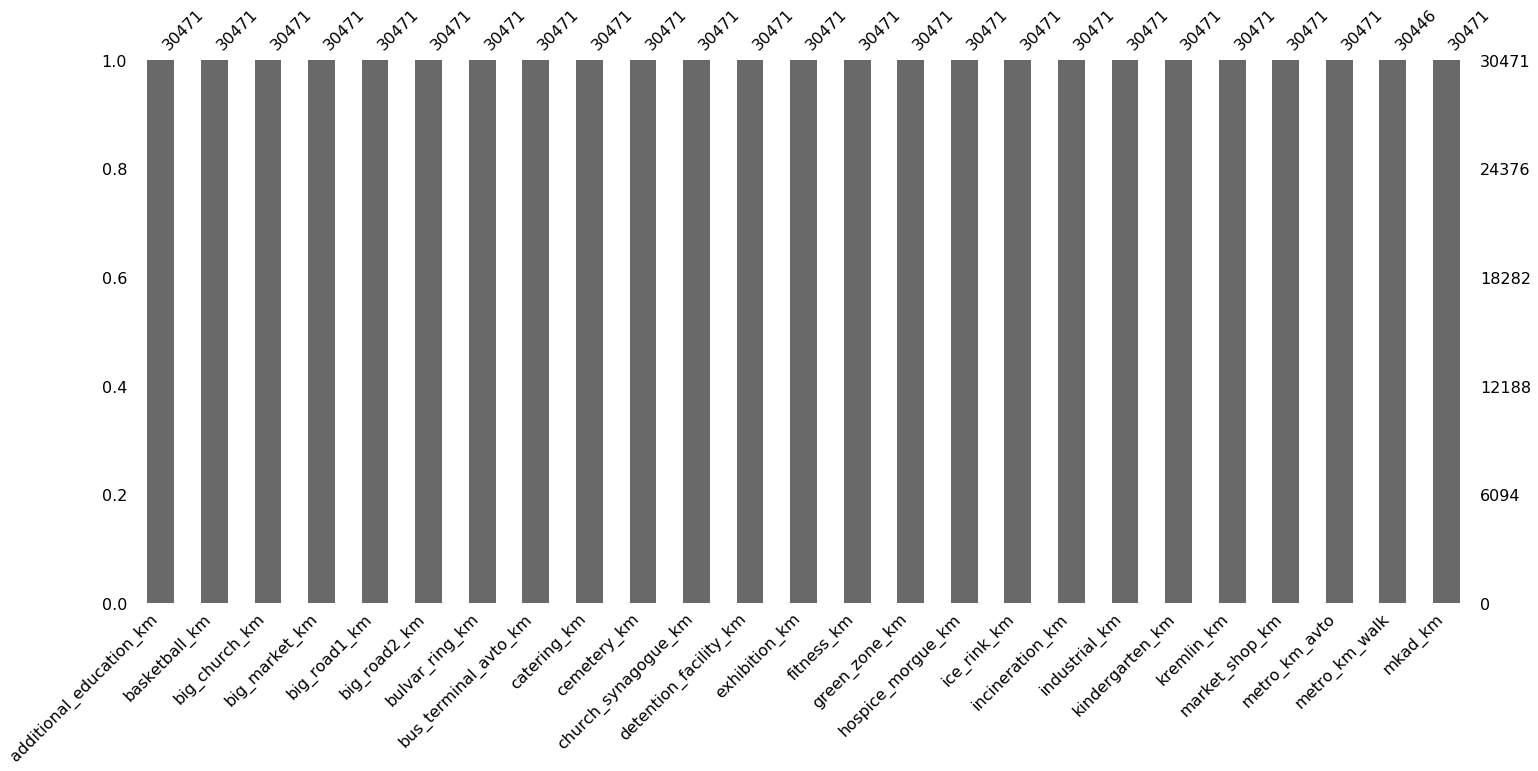

In [17]:
msno.bar(df_eda[km_list[:25]])

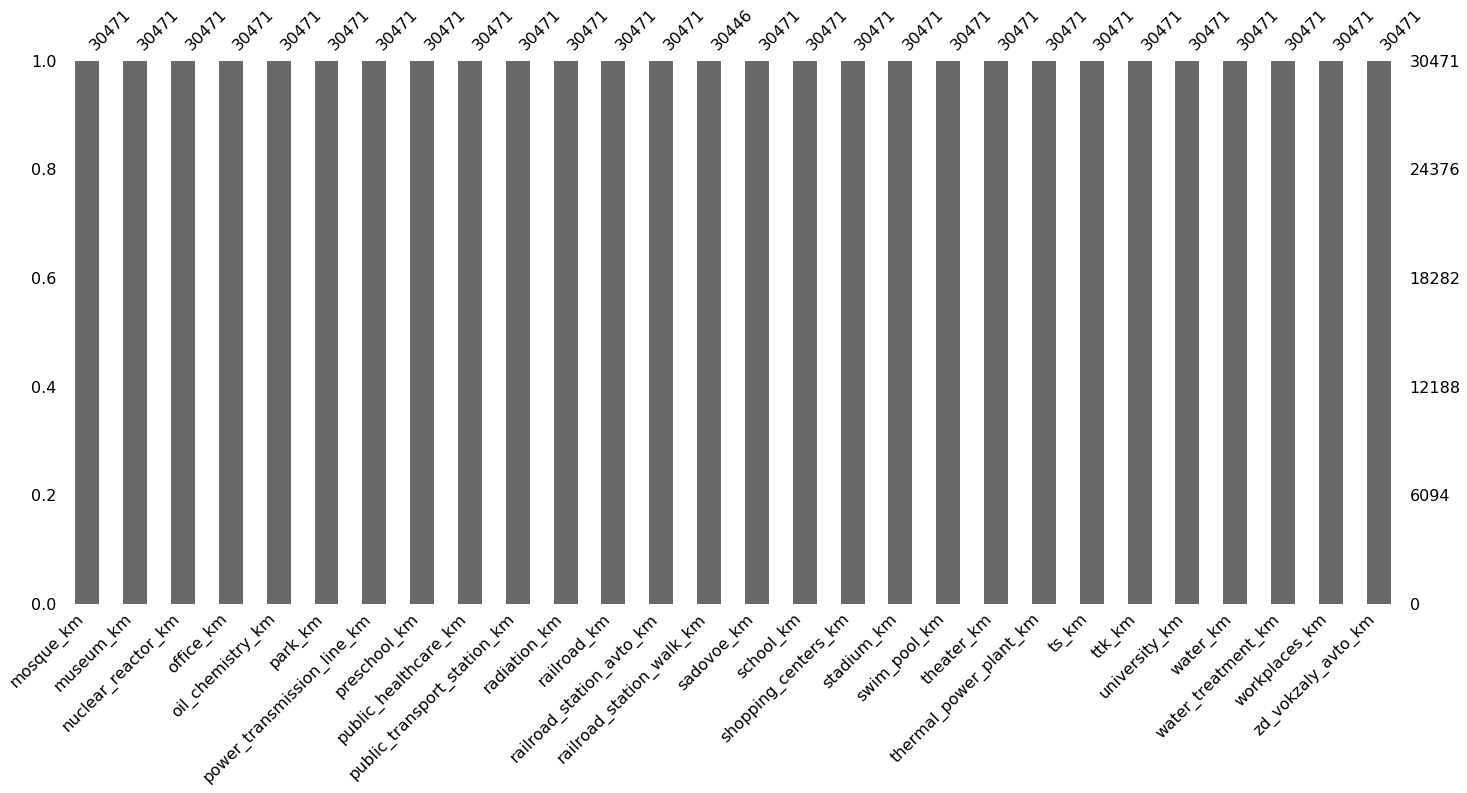

In [18]:
msno.bar(df_eda[km_list[25:]])

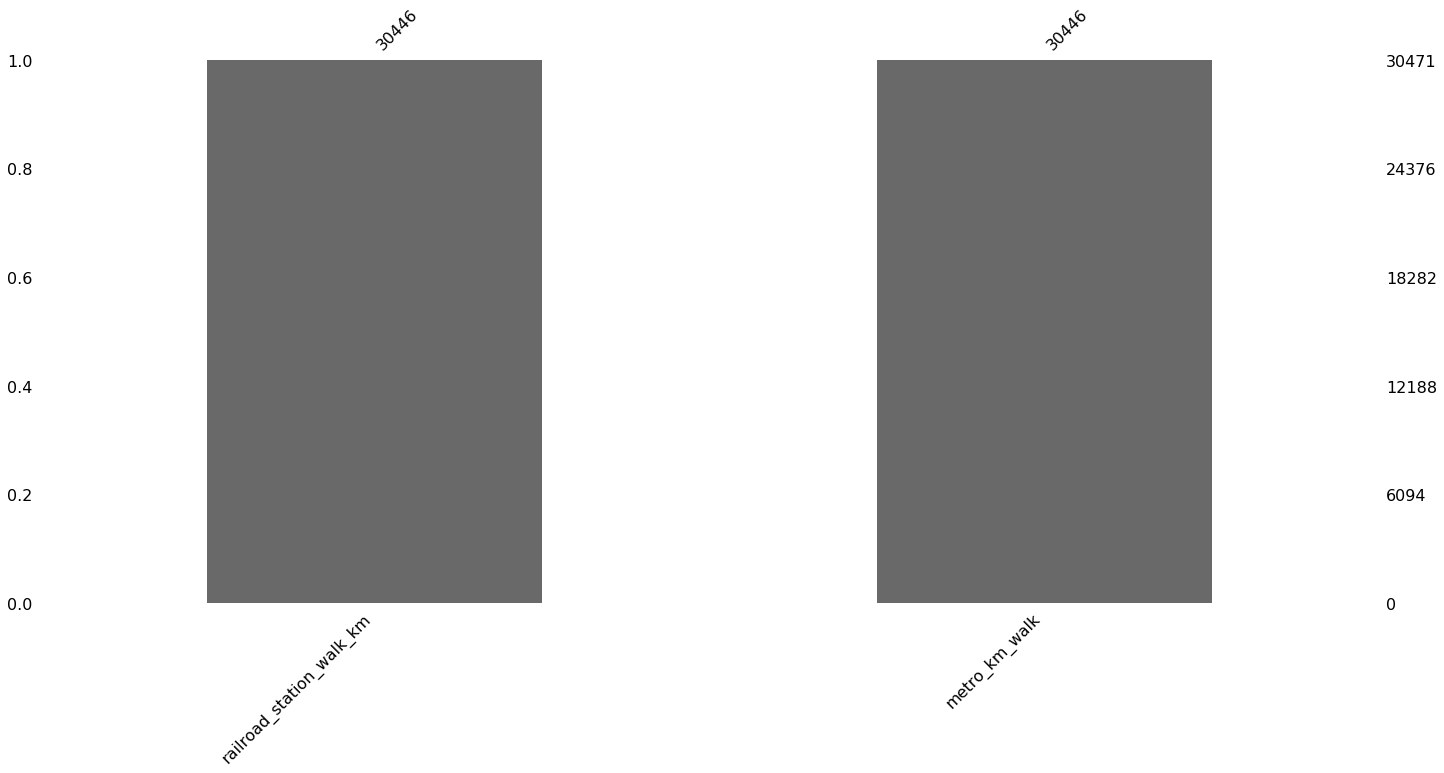

In [19]:
msno.bar(df_eda[['railroad_station_walk_km', 'metro_km_walk']])

The 3 graphs above show that the columns that make up km_list, which is used below to create km_sum, are almost entirely complete. The only exceptions are 'railroad_station_walk_km' and 'metro_km_walk' which appear to be missing about 25 values each. 

In [20]:
# fix the null columns

def fix_num_cols(dframe, skiplist, dropcol=1):
    """ Takes a dataframe, a list of fields to skip and whether to drop a column or not.
    For every numeric field a NaN is replaced with the median for that column.
    A new dataframe is returned. 
    """
    n = 0
    m = 0
    df_tmp = dframe.copy()
    for col in df_tmp.columns.values:
        if col not in skiplist:
            if isinstance(df_tmp[col].dtype,((object))):
                try:
                    df_tmp[col].fillna(df_tmp[col].median(), inplace=True)
                except:
                    if dropcol:
                        df_tmp.drop(col, inplace=True, axis=1)
                    else:
                        df_tmp[col].fillna('NUL', inplace=True)
    return df_tmp

In [21]:
print (dt.datetime.now())    
skip = ['price_cat','id','timestamp','price_doc', 'price_category']
df_train = fix_num_cols(df_eda, skip)
print (dt.datetime.now())    

2019-02-19 10:07:57.814778
2019-02-19 10:07:59.191877


### Feature Engineering
In an attempt to try and get better results linear combinations of some of the features will be performed where they are deemed to make sense.

In [22]:
def make_list(grep_name, ignore_name='ignore'):
    """ Takes a string to 'grep' for and an [optional] string to ignore and 
    gets a list of columns with that string as the root of the column names. 
    These columns will be used subsequently to sum up and create new features.
    """
    count_list = []
    for col in df_eda.columns:
        if grep_name in col and ignore_name not in col:
            count_list.append(col)
            
    return count_list

In [23]:
# create lists of columns to be summed into new features
cafe_sum_min_list = ['cafe_sum_500_min_price_avg', 'cafe_sum_1000_min_price_avg', 'cafe_sum_1500_min_price_avg', \
 'cafe_sum_2000_min_price_avg', 'cafe_sum_3000_min_price_avg', 'cafe_sum_5000_min_price_avg']
cafe_sum_max_list = ['cafe_sum_500_max_price_avg', 'cafe_sum_1000_max_price_avg', 'cafe_sum_1500_max_price_avg', '\
cafe_sum_2000_max_price_avg', 'cafe_sum_3000_max_price_avg', 'cafe_sum_5000_max_price_avg']
build_count_list = ['build_count_block', 'build_count_wood', 'build_count_frame', 'build_count_brick', \
 'build_count_monolith','build_count_panel', 'build_count_foam', 'build_count_slag', 'build_count_mix', \
 'build_count_before_1920','build_count_1921-1945', 'build_count_1946-1970', 'build_count_1971-1995',\
 'build_count_after_1995']
raion_build_list = ['raion_build_count_with_material_info', 'raion_build_count_with_builddate_info']
big_church_count_list = ['big_church_count_500', 'big_church_count_1000', 'big_church_count_1500',\
                         'big_church_count_2000', 'big_church_count_3000', 'big_church_count_5000']
cafe_count_list = make_list('cafe_count')
church_count_list = make_list('church_count', 'big_church')
leisure_count_list = make_list('leisure_count')
market_count_list = make_list('market_count')
office_count_list = make_list('office_count')
sport_count_list = make_list('sport_count')
trc_count_list = make_list('trc_count')

make_list('_count_5000_')

['cafe_count_5000_na_price',
 'cafe_count_5000_price_500',
 'cafe_count_5000_price_1000',
 'cafe_count_5000_price_1500',
 'cafe_count_5000_price_2500',
 'cafe_count_5000_price_4000',
 'cafe_count_5000_price_high']

In [24]:
# create the new features
print (dt.datetime.now())    
df_train['diff_sq'] = df_train['full_sq'] - df_train['kitch_sq']
df_train['plus_sq'] = df_train['full_sq'] + df_train['life_sq'] 
df_train['km_sum'] = df_train[km_list].apply(lambda x: sum(x), axis=1)
df_train['cafe_sum_min_total'] = df_train[cafe_sum_min_list].apply(lambda x: sum(x), axis=1)
df_train['cafe_sum_max_total'] = df_train[cafe_sum_max_list].apply(lambda x: sum(x), axis=1)    
df_train['build_count_total'] = df_train[build_count_list].apply(lambda x: sum(x), axis=1)
df_train['raion_build_count_total'] = df_train[raion_build_list].apply(lambda x: sum(x), axis=1)
df_train['big_church_count_total'] = df_train[big_church_count_list].apply(lambda x: sum(x), axis=1)
df_train['cafe_count_total'] = df_train[cafe_count_list].apply(lambda x: sum(x), axis=1)
df_train['church_count_total'] = df_train[church_count_list].apply(lambda x: sum(x), axis=1)
df_train['leisure_count_total'] = df_train[leisure_count_list].apply(lambda x: sum(x), axis=1)
df_train['market_count_total'] = df_train[market_count_list].apply(lambda x: sum(x), axis=1)
df_train['office_count_total'] = df_train[office_count_list].apply(lambda x: sum(x), axis=1)
df_train['sport_count_total'] = df_train[sport_count_list].apply(lambda x: sum(x), axis=1)
df_train['trc_count_total'] = df_train[trc_count_list].apply(lambda x: sum(x), axis=1)
df_train['count_500_total'] = df_train[make_list('_count_500_')].apply(lambda x: sum(x), axis=1)
df_train['count_1000_total'] = df_train[make_list('_count_1000_')].apply(lambda x: sum(x), axis=1)
df_train['count_2000_total'] = df_train[make_list('_count_2000_')].apply(lambda x: sum(x), axis=1)
df_train['count_3000_total'] = df_train[make_list('_count_3000_')].apply(lambda x: sum(x), axis=1)
df_train['count_5000_total'] = df_train[make_list('_count_5000_')].apply(lambda x: sum(x), axis=1)

print (dt.datetime.now())    

2019-02-19 10:07:59.698847
2019-02-19 10:08:16.620717


In [25]:
# divide the indexes into different lists per price category
idx0 = df_train[df_train['price_category'] == 0].index
idx1 = df_train[df_train['price_category'] == 1].index
idx2 = df_train[df_train['price_category'] == 2].index
print(len(idx0))
print(len(idx1))
print(len(idx2))

10164
10198
10109


In [26]:
x_list = [col for col in df_train.columns if col not in skip]
print(len(x_list))

390


In [27]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_train.loc[:, x_list], \
                                                    df_train.loc[:, 'price_category'], test_size=0.3)
X_train.shape

(21329, 390)

## Feature Selection

2019-02-19 10:08:17.823129
2019-02-19 10:12:45.711732


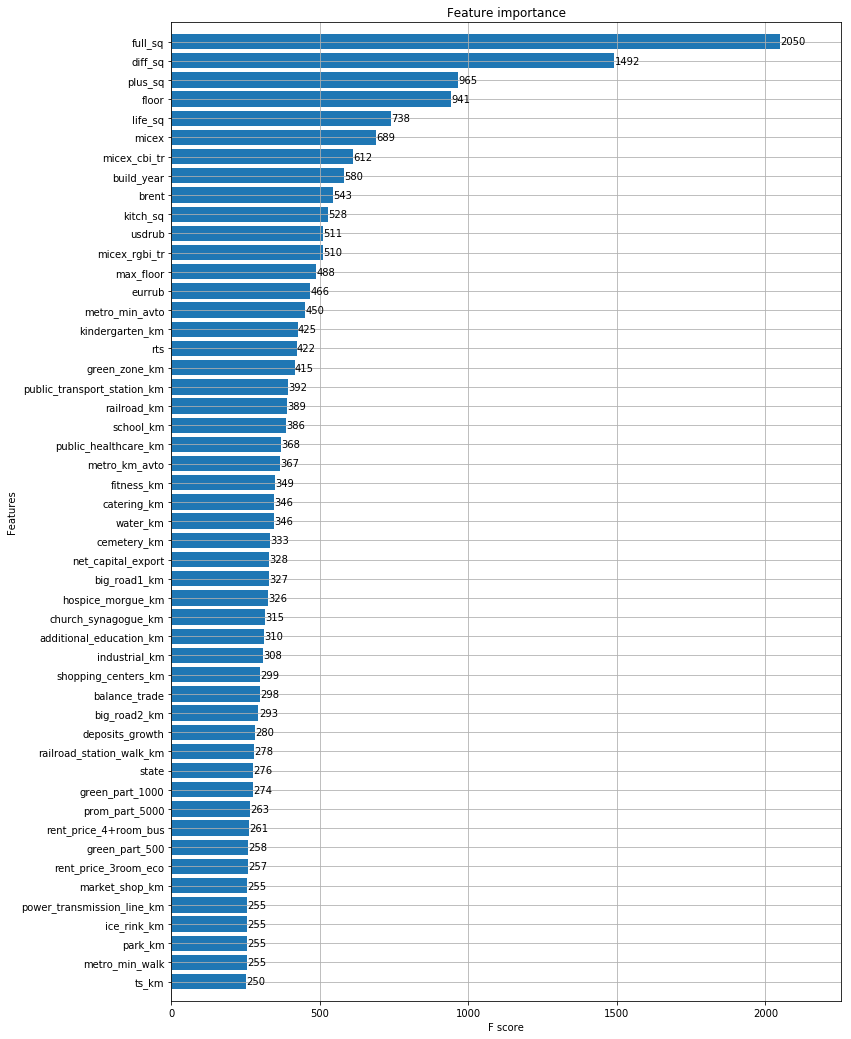

In [28]:
print (dt.datetime.now())    
for f in X_train.columns:
    if X_train[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values)) 
        X_train[f] = lbl.transform(list(X_train[f].values))
        
train_y = y_train
train_X = X_train

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
     'num_class': 4,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'multi:softmax',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=100)



# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
print (dt.datetime.now())    
plt.show()


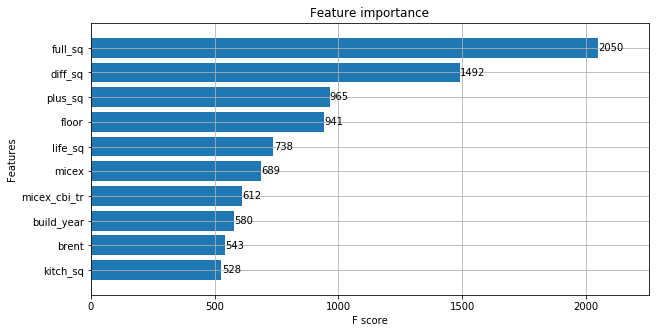

In [29]:
# plot the important features #
fig, ax = plt.subplots(figsize=(10,5))
xgb.plot_importance(model, max_num_features=10, height=0.8, ax=ax) 
plt.show()

In [107]:
flist = ['full_sq','diff_sq','plus_sq','floor','life_sq','micex','micex_cbi_tr', 'build_year', 'usdrub','max_floor']
flist

['full_sq',
 'diff_sq',
 'plus_sq',
 'floor',
 'life_sq',
 'micex',
 'micex_cbi_tr',
 'build_year',
 'usdrub',
 'max_floor']

In [31]:
slist = slist + ['diff_sq', 'plus_sq', 'km_sum']

/Users/chadleonard/Springboard/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/chadleonard/Springboard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


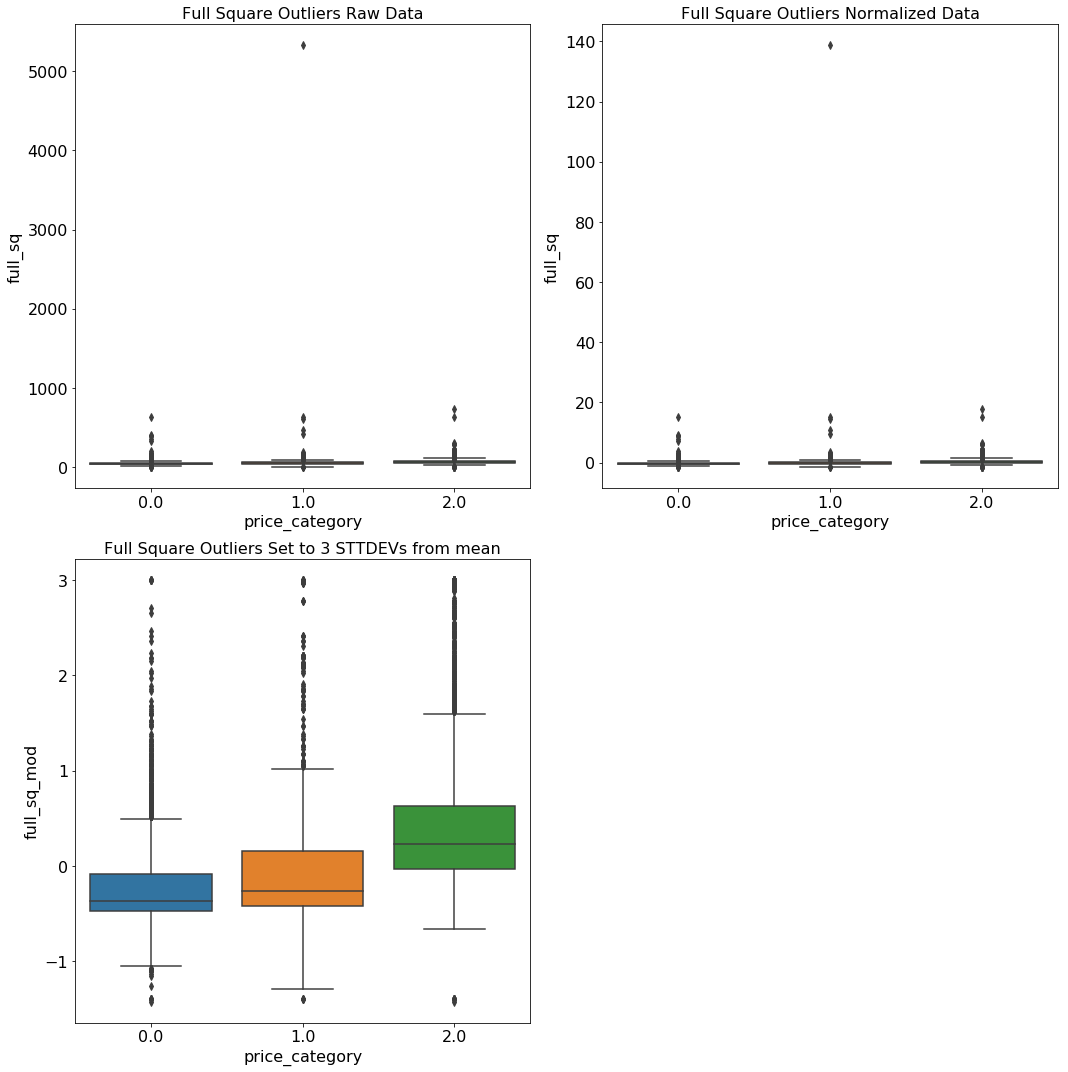

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
sns.catplot(x="price_category", y='full_sq', kind="box", data=df_train[['price_category','full_sq']], ax=axes[0][0])
axes[0][0].set_title("Full Square Outliers Raw Data", size=16)
axes[0][0].xaxis.label.set_fontsize(16)
axes[0][0].yaxis.label.set_fontsize(16)
axes[0][0].tick_params(axis = 'x', which = 'major', labelsize = 16)
axes[0][0].tick_params(axis = 'y', which = 'major', labelsize = 16)

# normalize the data
scaler = StandardScaler()
scaler.fit(df_train[slist])
df_norm = pd.DataFrame(scaler.transform(df_train[slist]), columns=slist)
df_norm['price_category'] = df_train['price_category']

sns.catplot(x="price_category", y='full_sq', kind="box", data=df_norm[['price_category','full_sq']], ax=axes[0][1])
axes[0][1].set_title("Full Square Outliers Normalized Data", size=16)
axes[0][1].xaxis.label.set_fontsize(16)
axes[0][1].yaxis.label.set_fontsize(16)
axes[0][1].tick_params(axis = 'x', which = 'major', labelsize = 16)
axes[0][1].tick_params(axis = 'y', which = 'major', labelsize = 16)

# change all values more than 3 stddevs from mean to 3 stddevs from mean in either direction
df_norm['full_sq_mod'] = df_norm['full_sq']
df_norm.loc[df_norm['full_sq'] > 3.0, 'full_sq_mod'] = 3.0
df_norm.loc[df_norm['full_sq'] < -3.0, 'full_sq_mod'] = -3.0

sns.catplot(x="price_category", y='full_sq_mod', kind="box", data=df_norm[['price_category','full_sq_mod']], ax=axes[1][0])
axes[1][0].set_title("Full Square Outliers Set to 3 STTDEVs from mean", size=16)
axes[1][0].xaxis.label.set_fontsize(16)
axes[1][0].yaxis.label.set_fontsize(16)
axes[1][0].tick_params(axis = 'x', which = 'major', labelsize = 16)
axes[1][0].tick_params(axis = 'y', which = 'major', labelsize = 16)

fig.tight_layout()
fig.delaxes(axes[1][1])
plt.close(2)
plt.close(3)
plt.close(4)

/Users/chadleonard/Springboard/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/chadleonard/Springboard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


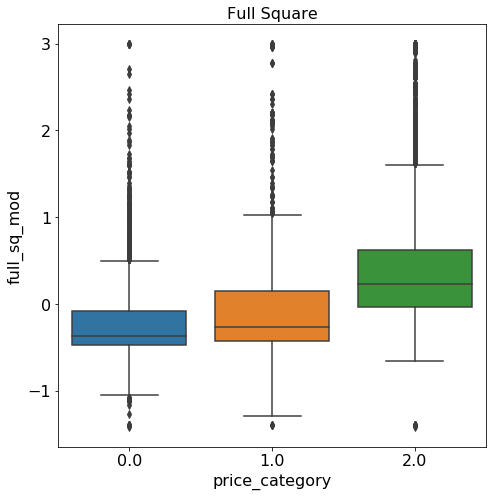

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,7))

# normalize the data
scaler = StandardScaler()
scaler.fit(df_train[slist])
df_norm = pd.DataFrame(scaler.transform(df_train[slist]), columns=slist)
df_norm['price_category'] = df_train['price_category']


# change all values more than 3 stddevs from mean to 3 stddevs from mean in either direction
df_norm['full_sq_mod'] = df_norm['full_sq']
df_norm.loc[df_norm['full_sq'] > 3.0, 'full_sq_mod'] = 3.0
df_norm.loc[df_norm['full_sq'] < -3.0, 'full_sq_mod'] = -3.0

sns.catplot(x="price_category", y='full_sq_mod', kind="box", data=df_norm[['price_category','full_sq_mod']], ax=axes)
axes.set_title("Full Square", size=16)
axes.yaxis.set_label('full_sq')
axes.xaxis.label.set_fontsize(16)
axes.yaxis.label.set_fontsize(16)

axes.tick_params(axis = 'x', which = 'major', labelsize = 16)
axes.tick_params(axis = 'y', which = 'major', labelsize = 16)

fig.tight_layout()
#fig.delaxes(axes[1][1])
plt.close(2)
plt.close(3)
plt.close(4)

In [34]:
df_eda[['full_sq', 'price_cat']].groupby('price_cat').mean()

,full_sq
price_cat,
1,45.331331
2,54.689673
3,78.883368


In [35]:
print('price_cat 0 min:', df_eda.loc[df_eda.price_cat== 0, 'full_sq'].min())
print('price_cat 0 max:',df_eda.loc[df_eda.price_cat== 0, 'full_sq'].max())
print('price_cat 1 min:',df_eda.loc[df_eda.price_cat== 1, 'full_sq'].min())
print('price_cat 1 max:',df_eda.loc[df_eda.price_cat== 1, 'full_sq'].max())
print('price_cat 2 min:',df_eda.loc[df_eda.price_cat== 2, 'full_sq'].min())
print('price_cat 2 max:',df_eda.loc[df_eda.price_cat== 2, 'full_sq'].max())
print('price_cat 3 min:',df_eda.loc[df_eda.price_cat== 3, 'full_sq'].min())
print('price_cat 3 max:',df_eda.loc[df_eda.price_cat== 3, 'full_sq'].max())

price_cat 0 min: nan
price_cat 0 max: nan
price_cat 1 min: 0
price_cat 1 max: 637
price_cat 2 min: 0
price_cat 2 max: 5326
price_cat 3 min: 1
price_cat 3 max: 729


In [36]:
vals = df_train.loc[idx0,'full_sq'].describe()
print('price_cat 0 outliers count:',(np.abs((df_train.loc[idx0,'full_sq'] - vals['mean']) / vals['std'] ) <= 3).sum())
ix0 = np.abs((df_train.loc[idx0,'full_sq'] - vals['mean']) / vals['std'] ) <= 3
print(sum(ix0 == True))
#print(df_train.loc[list(ix0),'full_sq'])
vals = df_train.loc[idx1,'full_sq'].describe()
print('price_cat 1 outliers count:',(np.abs((df_train.loc[idx1,'full_sq'] - vals['mean']) / vals['std'] ) <= 3).sum())
ix1 = np.abs((df_train.loc[idx1,'full_sq'] - vals['mean']) / vals['std'] ) <= 3
vals = df_train.loc[idx2,'full_sq'].describe()
print('price_cat 2 outliers count:',(np.abs((df_train.loc[idx2,'full_sq'] - vals['mean']) / vals['std'] ) <= 3).sum())
ix2 = np.abs((df_train.loc[idx2,'full_sq'] - vals['mean']) / vals['std'] ) <= 3


price_cat 0 outliers count: 10085
10085
price_cat 1 outliers count: 10193
price_cat 2 outliers count: 9934


In [37]:
len(list(df_train.loc[list(ix1)].index))

10193

In [38]:
np.corrcoef(df_train.loc[:,'full_sq'], df_train.loc[:,'price_cat'])

array([[1.        , 0.28893742],
       [0.28893742, 1.        ]])

In [39]:
np.corrcoef(df_train.loc[:,'full_sq'], df_train.loc[:,'price_category'])

array([[1.        , 0.25517154],
       [0.25517154, 1.        ]])

In [40]:
df_train.loc[list(ix0), 'full_sq'].max()

5326

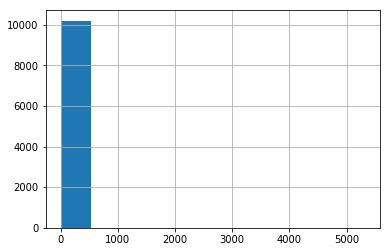

In [41]:
df_train.loc[list(ix1), 'full_sq'].hist()

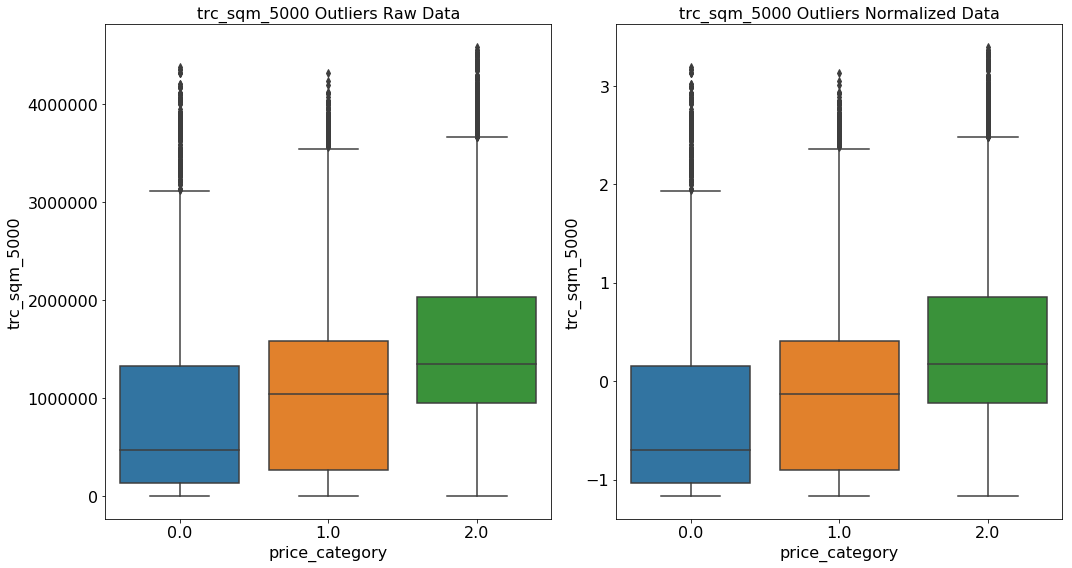

In [42]:
fig, axes = plt.subplots(ncols=2, figsize=(15,8))
sns.catplot(x="price_category", y='trc_sqm_5000', kind="box", data=df_train[['price_category','trc_sqm_5000']],ax=axes[0])
axes[0].set_title("trc_sqm_5000 Outliers Raw Data", size=16)
axes[0].xaxis.label.set_fontsize(16)
axes[0].yaxis.label.set_fontsize(16)
axes[0].tick_params(axis = 'x', which = 'major', labelsize = 16)
axes[0].tick_params(axis = 'y', which = 'major', labelsize = 16)


sns.catplot(x="price_category", y='trc_sqm_5000', kind="box", data=df_norm[['price_category','trc_sqm_5000']],ax=axes[1])
axes[1].set_title("trc_sqm_5000 Outliers Normalized Data", size=16)
axes[1].xaxis.label.set_fontsize(16)
axes[1].yaxis.label.set_fontsize(16)
axes[1].tick_params(axis = 'x', which = 'major', labelsize = 16)
axes[1].tick_params(axis = 'y', which = 'major', labelsize = 16)

fig.tight_layout()
plt.close(2)
plt.close(3)


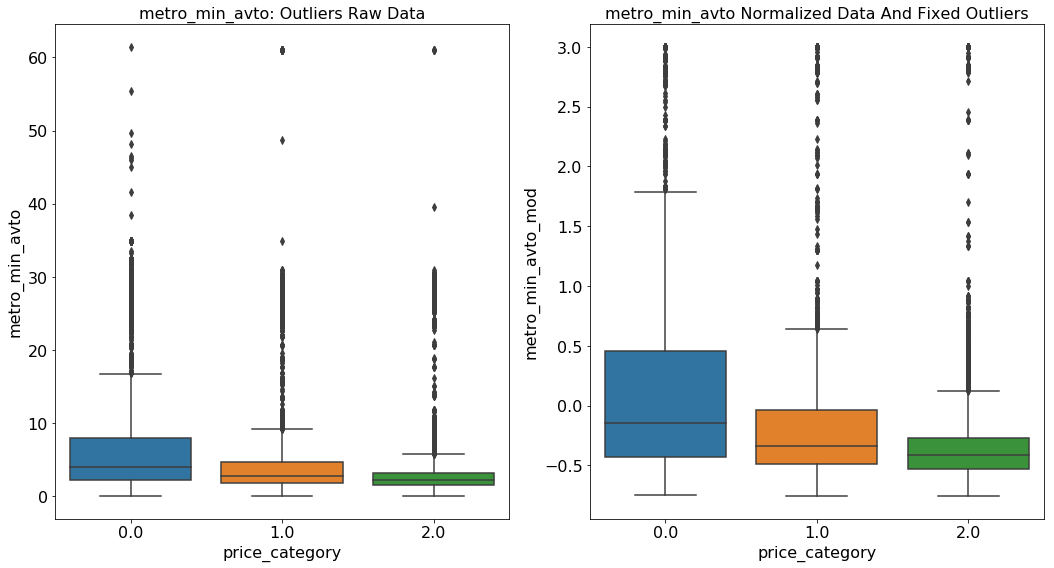

In [43]:
fig, axes = plt.subplots(ncols=2, figsize=(15,8))
sns.catplot(x="price_category", y='metro_min_avto', kind="box", data=df_train[['price_category','metro_min_avto']],ax=axes[0])
axes[0].set_title("metro_min_avto: Outliers Raw Data", size=16)
axes[0].xaxis.label.set_fontsize(16)
axes[0].yaxis.label.set_fontsize(16)
axes[0].tick_params(axis = 'x', which = 'major', labelsize = 16)
axes[0].tick_params(axis = 'y', which = 'major', labelsize = 16)

col='metro_min_avto'
df_norm[col+'_mod'] = df_norm[col]
df_norm.loc[df_norm[col] > 3.0, col+'_mod'] = 3.0
df_norm.loc[df_norm[col] < -3.0, col+'_mod'] = -3.0

sns.catplot(x="price_category", y='metro_min_avto_mod', kind="box", data=df_norm[['price_category','metro_min_avto_mod']],\
            ax=axes[1])
axes[1].set_title("metro_min_avto Normalized Data And Fixed Outliers", size=16)
axes[1].xaxis.label.set_fontsize(16)
axes[1].yaxis.label.set_fontsize(16)
axes[1].tick_params(axis = 'x', which = 'major', labelsize = 16)
axes[1].tick_params(axis = 'y', which = 'major', labelsize = 16)

fig.tight_layout()
plt.close(2)
plt.close(3)

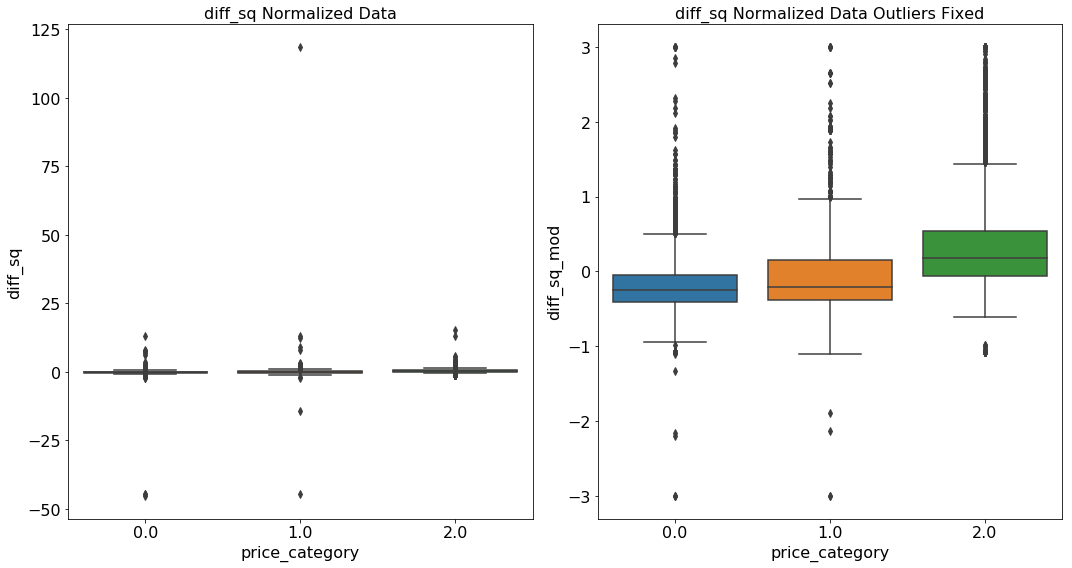

In [44]:
fig, axes = plt.subplots(ncols=2, figsize=(15,8))
sns.catplot(x="price_category", y='diff_sq', kind="box", data=df_norm[['price_category','diff_sq']],ax=axes[0])
axes[0].set_title("diff_sq Normalized Data", size=16)
axes[0].xaxis.label.set_fontsize(16)
axes[0].yaxis.label.set_fontsize(16)
axes[0].tick_params(axis = 'x', which = 'major', labelsize = 16)
axes[0].tick_params(axis = 'y', which = 'major', labelsize = 16)

col='diff_sq'
df_norm[col+'_mod'] = df_norm[col]
df_norm.loc[df_norm[col] > 3.0, col+'_mod'] = 3.0
df_norm.loc[df_norm[col] < -3.0, col+'_mod'] = -3.0

sns.catplot(x="price_category", y='diff_sq_mod', kind="box", data=df_norm[['price_category','diff_sq_mod']],ax=axes[1])
axes[1].set_title("diff_sq Normalized Data Outliers Fixed", size=16)
axes[1].xaxis.label.set_fontsize(16)
axes[1].yaxis.label.set_fontsize(16)
axes[1].tick_params(axis = 'x', which = 'major', labelsize = 16)
axes[1].tick_params(axis = 'y', which = 'major', labelsize = 16)

fig.tight_layout()
plt.close(2)
plt.close(3)

## Classifier Results
In a separate notebook multiple classifiers with various hyperparameters were run using sklearn's GridSearchCV. A spreadsheet, 'ClassifierAccuracy.xlsx', was created to record the best 'accuracy' scores for the many different classifiers that were run. Below shows the results of the many runs.

In the end the best result was an accuracy score of about 80 or 81 percent. The best scores were achieved with only a handful of features. Three of the fields ('km_sum', 'diff_sq' and 'plus_sq') are linear combinations of other fields. The rest of the fields (12 to be exact) are taken right from the raw data with only some of them having nulls replaced with the median for that column. 

Replacing nulls was important for the final results, but neither normalizing the data nor taking care of outliers made any appreciable improvement in the end results for most of the models. The final model settled on is the XGB Boost Classifier. It was also used to determine feature importance. The results of XGB are in the very last cell.  

## Notes
*find out what the differences in classifiers are*
*feature importance for classifiers and coefficient for linear models*
*plot the coefficients for linear models*
*use AUC*

*sns.pairplot for the top five variables
temp = data[['full_sq', 'diff_sq', 'plus_sq', 'label']].copy() 
sns.pairplot(temp, diag_kind='kde', hue='label') 
need some explanations for the differences in classes use plot above. 
need some descriptions of the plots
two types of charts
1) some for my use
2) others are for your audience


*hypothesis 
*how do labels compare to feature importance. 

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

In [45]:
df_class = pd.read_excel('ClassifierAccuracy.xlsx')
df_class[['Classifier','Accuracy']].head()

,Classifier,Accuracy
0,XGBClassifier,0.816456
1,GradientBoostingClassifier,0.803422
2,RandomForestClassifier,0.788777
3,MLPClassifier,0.787436
4,LinearSVC_PCA,0.765213


In [46]:
class_list = []
single_list = []
for rec in df_class[['Classifier','Accuracy']].values:
    #print(rec[0])
    single_list.append(rec[0])
    val = int(rec[1]*100)
    #print(val)
    for a in range(val):
        class_list.append(rec[0])
        
print(class_list[:5])

['XGBClassifier', 'XGBClassifier', 'XGBClassifier', 'XGBClassifier', 'XGBClassifier']


### Accuracy scores for the various classifiers

Text(0.5, 0, 'Classifiers')

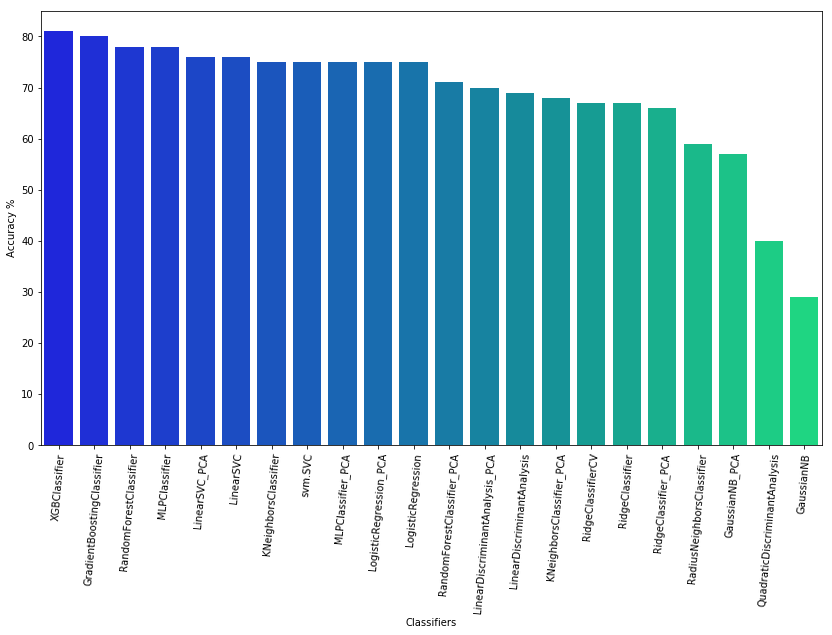

In [47]:
plt.figure(figsize=(14, 8))
g = sns.countplot(x="classifiers", data=pd.DataFrame(class_list, columns=['classifiers']), palette="winter")
g.set_xticklabels(single_list,rotation=85)
plt.ylabel('Accuracy %')
plt.xlabel('Classifiers')


In [48]:
alist = ['full_sq','trc_sqm_5000', 'cafe_avg_price_5000', 'metro_min_avto', 'trc_sqm_2000'\
        ,'16_29_male', 'area_m','raion_popul','km_sum', 'diff_sq', 'plus_sq', 'micex', 'floor', \
        'micex_cbi_tr','brent']
flist = alist
print(len(flist))


15


In [49]:
# final model
print (dt.datetime.now())    
dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns)
#dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns.values)
model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=100)

xg_test = xgb.DMatrix(X_test, label=y_test)
#xg_test = xgb.DMatrix(X_test, label=y_test)
pred = model.predict(xg_test)
error_rate = np.sum(pred != y_test) / y_test.shape[0]
accuracy = np.sum(pred == y_test) / y_test.shape[0]
print('Test error using softmax = {}'.format(error_rate))
print('Test accuracy using softmax = {}'.format(accuracy))
print (dt.datetime.now())    

2019-02-19 10:12:56.653530
Test error using softmax = 0.2006125574272588
Test accuracy using softmax = 0.7993874425727412
2019-02-19 10:17:26.758135


In [50]:
out0 = np.sum(pred == 0)
print(out0)
print(np.sum(y_test == 0) / out0)
print( out0 / np.sum(y_test == 0) )
out1 = np.sum(pred == 1)
print(out1)
print(np.sum(y_test == 1)/out1)
out2 = np.sum(pred == 2)
print(out2)
print(np.sum(y_test == 2)/out2)

(np.sum(y_test == 2) + np.sum(y_test == 1)) / (out1+out2)

2370
1.270886075949367
0.7868525896414342
3402
0.9027042915931804
3370
0.9077151335311573


0.9051978735971647

In [51]:
print (dt.datetime.now()) 
xg_train = xgb.DMatrix(X_train, label=y_train)
#xg_test = xgb.DMatrix(X_test, label=y_test)
pred = model.predict(xg_train)
error_rate = np.sum(pred != y_train) / y_train.shape[0]
accuracy = np.sum(pred == y_train) / y_train.shape[0]
print('Training error using softmax = {}'.format(error_rate))
print('Training accuracy using softmax = {}'.format(accuracy))
print (dt.datetime.now()) 

2019-02-19 10:17:26.807343
Training error using softmax = 0.10675605982465189
Training accuracy using softmax = 0.8932439401753481
2019-02-19 10:17:28.641127


In [51]:
out0 = np.sum(pred == 0)
print(out0)
print(np.sum(y_train == 0) / out0)
print( out0 / np.sum(y_train == 0) )
out1 = np.sum(pred == 1)
print(out1)
print(np.sum(y_train == 1)/out1)
out2 = np.sum(pred == 2)
print(out2)
print(np.sum(y_train == 2)/out2)

(np.sum(y_train == 2) + np.sum(y_train == 1)) / (out1+out2)

5822
1.2207145310889729
0.8191923455747854
7764
0.9255538382277176
7743
0.9086917215549528


0.917134197459212

In [54]:
X_test.shape

(9142, 390)

In [ ]:
xlist = ['class0_proba','class1_proba','class2_proba','class3_proba']

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(alpha=0.01,hidden_layer_sizes=(100,100,75,75,50,), activation='relu')
#X = np.array(X_train).reshape(650,1)
#Xt = np.array(X_test).reshape(279,1)
clf.fit(X_train, y_train)
print(clf.score(X_test,y_test))
print(clf.score(X_train,y_train))

In [ ]:
clf.score(np.array(df_train.loc[:,'full_sq']).reshape(-1,1), df_train.loc[:,'price_cat'])

In [ ]:
flist = [col for col in X_new.columns if col not in ['price_cat','price_doc', 'full_sq']]
flist

In [ ]:
ixx = df_train.loc[df_train.build_year != 9999,'build_year'].index

In [ ]:
np.corrcoef(df_train[['build_year', 'full_sq', 'price_cat']])

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_new.loc[:, flist], \
                                                                df_train.loc[X_new.index, 'price_cat'], test_size=0.3)
#X_train.reshape(650,1)
X_train.shape

In [ ]:
for col in df_train.columns:
    if 'price_doc' in col or 'price_cat' in col:
        print(col)

In [ ]:
clf = MLPClassifier(alpha=1,hidden_layer_sizes=(100,100,), activation='relu',criterion='entropy')
clf.fit(X_train, y_train)
print(clf.score(X_train,y_train))
print(clf.score(X_test, y_test))


In [ ]:
print (dt.datetime.now()) 
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=11, n_estimators=250,criterion='gini',bootstrap=False,max_leaf_nodes=200)
clf.fit(X_train, y_train)
print(clf.score(X_train,y_train))
print(clf.score(X_test, y_test))
print (dt.datetime.now()) 

In [ ]:
print (dt.datetime.now()) 
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=11, n_estimators=100,criterion='entropy',bootstrap=True)
clf.fit(X_train, y_train)
print(clf.score(X_train,y_train))
print(clf.score(X_test, y_test))
print (dt.datetime.now()) 

In [54]:
X_train.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,leisure_count_total,market_count_total,office_count_total,sport_count_total,trc_count_total,count_500_total,count_1000_total,count_2000_total,count_3000_total,count_5000_total
15222,61,30.0,17.0,17.0,1.0,2015.0,2.0,10.0,2.0,2.553630e+07,...,1,0,1,18,8,1,2,6,9,20
502,131,69.0,17.0,12.0,1.0,9999.0,2.0,6.0,2.0,1.132409e+07,...,6,11,20,39,41,0,2,8,8,72
10155,50,33.0,2.0,12.0,5.0,1972.0,2.0,6.0,3.0,5.391434e+06,...,8,32,85,116,85,3,17,47,87,274
14795,42,26.0,5.0,5.0,2.0,1961.0,2.0,5.0,2.0,4.934147e+06,...,4,7,43,155,42,2,16,33,58,133
5404,84,52.0,11.0,12.0,1.0,9999.0,2.0,6.0,2.0,1.139168e+07,...,0,2,0,5,5,0,0,0,3,14


In [91]:
x_list = [col for col in df_train.columns if col not in skip]
x_list

['full_sq',
 'life_sq',
 'floor',
 'max_floor',
 'material',
 'build_year',
 'num_room',
 'kitch_sq',
 'state',
 'area_m',
 'raion_popul',
 'green_zone_part',
 'indust_part',
 'children_preschool',
 'preschool_quota',
 'preschool_education_centers_raion',
 'children_school',
 'school_quota',
 'school_education_centers_raion',
 'school_education_centers_top_20_raion',
 'hospital_beds_raion',
 'healthcare_centers_raion',
 'university_top_20_raion',
 'sport_objects_raion',
 'additional_education_raion',
 'culture_objects_top_25_raion',
 'shopping_centers_raion',
 'office_raion',
 'full_all',
 'male_f',
 'female_f',
 'young_all',
 'young_male',
 'young_female',
 'work_all',
 'work_male',
 'work_female',
 'ekder_all',
 'ekder_male',
 'ekder_female',
 '0_6_all',
 '0_6_male',
 '0_6_female',
 '7_14_all',
 '7_14_male',
 '7_14_female',
 '0_17_all',
 '0_17_male',
 '0_17_female',
 '16_29_all',
 '16_29_male',
 '16_29_female',
 '0_13_all',
 '0_13_male',
 '0_13_female',
 'raion_build_count_with_mater

In [92]:
# Import necessary modules
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.layers import Dropout


X_train = df_train.loc[:, x_list]
y_train = df_train.loc[:, 'price_category']

scaler = StandardScaler()
scaler.fit(X_train)
df_norm = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

#scaler.fit(X_test)
#df_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


/Users/chadleonard/Springboard/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/chadleonard/Springboard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [88]:
df_train['sub_area'] = df_eda.sub_area
df_train.sub_area.head()

0             Bibirevo
1    Nagatinskij Zaton
2       Tekstil'shhiki
3               Mitino
4            Basmannoe
Name: sub_area, dtype: object

In [89]:
print(df_train.shape)
df_train = pd.get_dummies(df_train)
print(df_train.shape)

(30471, 394)
(30471, 539)


In [70]:
print(df_norm.shape)
y_train.shape

(30471, 390)


(30471,)

In [93]:
print (dt.datetime.now()) 
n_cols = X_train.shape[1]


opt = SGD(lr=0.01)

# Set up the model
model = Sequential()

# Add the first layer
model.add(Dense(n_cols,activation='relu', input_shape=(n_cols,)))
model.add(Dense(n_cols,activation='relu' ))
model.add(Dense(200,activation='relu' ))
model.add(Dense(150,activation='relu' ))
model.add(Dense(150,activation='relu' ))
model.add(Dense(200,activation='relu' ))
model.add(Dense(200,activation='relu' ))
model.add(Dropout(0.2))
model.add(Dense(150,activation='relu' ))
model.add(Dense(50,activation='relu' ))
model.add(Dense(10,activation='relu' ))
# Add the output layer
model.add(Dense(3,activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
model.fit(df_norm,to_categorical(y_train), epochs=20, batch_size=32, validation_split=0.1)
print (dt.datetime.now()) 


2019-02-19 11:36:05.082601
Train on 27423 samples, validate on 3048 samples
Epoch 1/20
27423/27423 [==============================] - 25s 905us/step - loss: 0.7683 - acc: 0.6614 - val_loss: 0.6935 - val_acc: 0.7231
Epoch 2/20
27423/27423 [==============================] - 20s 746us/step - loss: 0.6502 - acc: 0.7334 - val_loss: 0.5981 - val_acc: 0.7703
Epoch 3/20
27423/27423 [==============================] - 20s 728us/step - loss: 0.6120 - acc: 0.7471 - val_loss: 0.7044 - val_acc: 0.7379
Epoch 4/20
27423/27423 [==============================] - 19s 702us/step - loss: 0.5872 - acc: 0.7629 - val_loss: 0.6239 - val_acc: 0.7546
Epoch 5/20
27423/27423 [==============================] - 19s 697us/step - loss: 0.5708 - acc: 0.7706 - val_loss: 0.6138 - val_acc: 0.7556
Epoch 6/20
27423/27423 [==============================] - 19s 703us/step - loss: 0.5535 - acc: 0.7759 - val_loss: 0.6250 - val_acc: 0.7621
Epoch 7/20
27423/27423 [==============================] - 19s 682us/step - loss: 0.5396 - 

In [64]:
to_categorical(y_test)

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [65]:
y_test.head()

13594    1.0
23720    2.0
30037    2.0
8999     1.0
11068    2.0
Name: price_category, dtype: float64

In [101]:
# Import KMeans
from sklearn.cluster import KMeans

# Create a KMeans instance with 3 clusters: model
model = KMeans(n_clusters=2)

# Fit model to points
model.fit(X_train)

# Determine the cluster labels of new_points: labels
labels = model.predict(X_train)

# Print cluster labels of new_points
print(labels)

[0 0 0 ... 0 0 0]


In [102]:
print(X_train.shape)
print(y_train.shape)

(30471, 536)
(30471,)


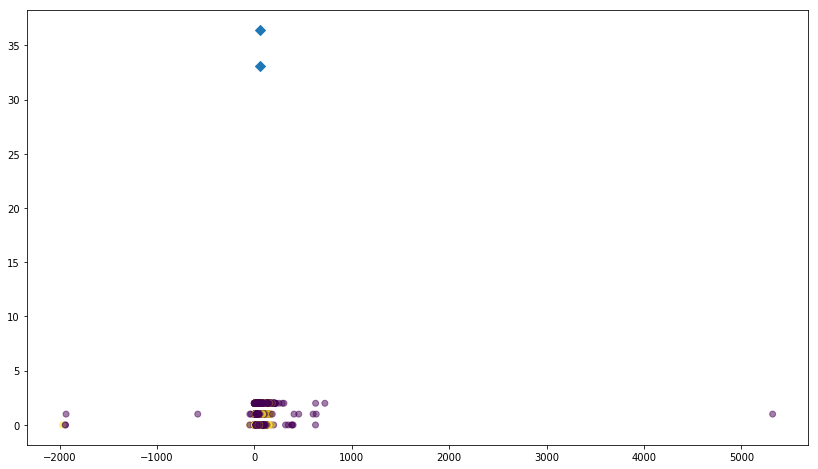

In [103]:
# Assign the columns of new_points: xs and ys
xs = X_train.diff_sq
ys = y_train

# Make a scatter plot of xs and ys, using labels to define the colors
plt.figure(figsize=(14, 8))
plt.scatter(xs,ys, c=labels, alpha=0.5)

# Assign the cluster centers: centroids
centroids = model.cluster_centers_

# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

# Make a scatter plot of centroids_x and centroids_y
plt.scatter(centroids_x,centroids_y, marker='D', s=50)
plt.show()

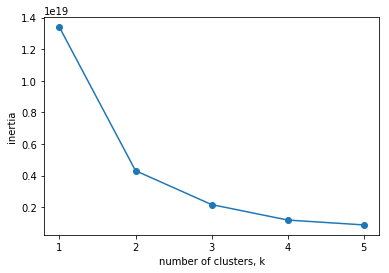

In [105]:
ks = range(1, 6)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(X_train)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [121]:
np.corrcoef(y_train, (X_train['diff_sq'],X_train['full_sq']))

array([[1.        , 0.20867494, 0.25517154],
       [0.20867494, 1.        , 0.850208  ],
       [0.25517154, 0.850208  , 1.        ]])

In [110]:
print(y_train.shape)
print(X_train.shape)

(30471,)
(30471, 536)


In [163]:
n=10
cov_mat = np.corrcoef(X_train[flist[:n]].T)

def format_cov(mat,columns):
    for i in range(len(columns)):
        c = columns[i].ljust(13, ' ') + ': \t'+ '\t' * i
        for a in mat[i][i:]:
            val = str(round(a,4))
            if a > 0.0:
                c =  c + ' '+ (val+ '000')[:6] + ' '
            else:
                c = c + (val+ '000')[:7] + ' '
        #print(len(c))  #len is 92
        print(c)
        
format_cov(cov_mat,flist[:n])

full_sq      : 	 1.0000  0.8502  0.7000  0.0891  0.1514  0.0178  0.0185  0.0275  0.0203  0.0576 
diff_sq      : 		 1.0000  0.5944  0.0800  0.1277  0.0155  0.0140  0.0577  0.0174  0.0384 
plus_sq      : 			 1.0000  0.0760  0.8119  0.0152  0.0221  0.0147  0.0193  0.0582 
floor        : 				 1.0000  0.0323 -0.0197 -0.0074  0.1085 -0.0169  0.3715 
life_sq      : 					 1.0000  0.0064  0.0155 -0.0022  0.0102  0.0334 
micex        : 						 1.0000  0.2805 -0.1168  0.5490  0.0108 
micex_cbi_tr : 							 1.0000 -0.5420  0.4948  0.0375 
build_year   : 								 1.0000 -0.3185 -0.0163 
usdrub       : 									 1.0000  0.0329 
max_floor    : 										 1.0000 


In [148]:
flist

['full_sq',
 'diff_sq',
 'plus_sq',
 'floor',
 'life_sq',
 'micex',
 'micex_cbi_tr',
 'build_year',
 'usdrub',
 'max_floor']